In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")

Using device: cuda

GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import functools
from PIL import Image
import argparse
import os
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

In [4]:
from PIL import Image
from torchvision import transforms
from core.ofa import OFATokenizer, OFAModel
from core.ofa.generate import sequence_generator

In [5]:
from core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset, VqaStackDataset
from core.ofa.label_smoothed_cross_entropy import AdjustLabelSmoothedCrossEntropyCriterion
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA
from core.ofa.configuration_ofa import OFAConfig
from accelerate import Accelerator
from accelerate.utils import DistributedDataParallelKwargs
from accelerate import DistributedType

In [6]:
import transformers

## Convert pt to pretrained bin

In [151]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/base_vqa_bowl/ofa_vqa.37500.pt"


In [152]:
kwargs = DistributedDataParallelKwargs(find_unused_parameters = True)
accelerator = Accelerator(kwargs_handlers = [kwargs])

In [153]:
# fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/results/ofa_vqa.32000.pt"
pkg = torch.load(fine_tuned, map_location = 'cpu')

In [154]:
ofa_config = OFAConfig.from_pretrained('/coc/scratch/sanisetty3/DLM/OFA-base-vqa/')
vqa_model = OFAModelForVQA(ofa_config)

In [155]:
unwrapped_model = accelerator.unwrap_model(vqa_model)

In [156]:
unwrapped_model.load_state_dict(pkg['model'])

<All keys matched successfully>

In [157]:
unwrapped_model.save_pretrained('/coc/scratch/sanisetty3/DLM/ofa-base-vqa-bowl/', save_function=accelerator.save)

##  Weight transfer to transformer model

In [79]:
model_b = OFAModelForVQA.from_pretrained("OFA-base/", use_cache=False)


In [81]:
base = torch.load("OFA-base/pytorch_model.bin")

In [172]:
base_vqa = torch.load("vqa_base_best.pt")["model"]
del base_vqa["encoder.version"]
del base_vqa["decoder.version"]

In [173]:
def change_key(self, old, new):
    for _ in range(len(self)):
        k, v = self.popitem(False)
        self[new if old == k else k] = v

In [174]:
 my_dic_keys = list(base_vqa.keys())

In [175]:
for i in my_dic_keys:
#     print(i)
    if "ffn_layernorm" in i and "encoder" in i:
        new = str(i).replace("ffn_layernorm","ffn_layer_norm")
        change_key(base_vqa , i , new)
        print(i)
    if "attn_ln" in i and "encoder" in i:
        new = str(i).replace("attn_ln","self_attn_mid_layer_norm")
        change_key(base_vqa , i , new)
        print(i)
        
    if "encoder_attn" in i and "decoder" in i:
        new = str(i).replace("encoder_attn","cross_attn")
        change_key(base_vqa , i , new)
        
    if "ffn_layernorm" in i and "decoder" in i:
        new = str(i).replace("ffn_layernorm","ffn_layer_norm")
        change_key(base_vqa , i , new) 
        
    if "cross_attn_ln" in i and "decoder" in i:
        new = str(i).replace("cross_attn_ln","cross_attn_mid_layer_norm")
        change_key(base_vqa , i , new) 
        
    if "self_attn_ln" in i and "decoder" in i:
        new = str(i).replace("self_attn_ln","self_attn_mid_layer_norm")
        change_key(base_vqa , i , new) 

encoder.layers.0.attn_ln.weight
encoder.layers.0.attn_ln.bias
encoder.layers.0.ffn_layernorm.weight
encoder.layers.0.ffn_layernorm.bias
encoder.layers.1.attn_ln.weight
encoder.layers.1.attn_ln.bias
encoder.layers.1.ffn_layernorm.weight
encoder.layers.1.ffn_layernorm.bias
encoder.layers.2.attn_ln.weight
encoder.layers.2.attn_ln.bias
encoder.layers.2.ffn_layernorm.weight
encoder.layers.2.ffn_layernorm.bias
encoder.layers.3.attn_ln.weight
encoder.layers.3.attn_ln.bias
encoder.layers.3.ffn_layernorm.weight
encoder.layers.3.ffn_layernorm.bias
encoder.layers.4.attn_ln.weight
encoder.layers.4.attn_ln.bias
encoder.layers.4.ffn_layernorm.weight
encoder.layers.4.ffn_layernorm.bias
encoder.layers.5.attn_ln.weight
encoder.layers.5.attn_ln.bias
encoder.layers.5.ffn_layernorm.weight
encoder.layers.5.ffn_layernorm.bias


In [176]:
mis = []
for i in (base_vqa.keys()):
    
    if i in base.keys():
        continue
    else:
        print(i)
        mis.append(i)

len(mis)

0

In [177]:
torch.save(base_vqa , "OFA-base-vqa/pytorch_model.bin")

In [178]:
model_p = OFAModelForVQA.from_pretrained("OFA-base-vqa/", use_cache=False)


## Test VQAv2

In [7]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)


NameError: name 'pretrained' is not defined

In [ ]:
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)
model_f = OFAModelForVQA.from_pretrained('/coc/scratch/sanisetty3/DLM/OFA-tiny-fine-tune/', use_cache=False)

In [ ]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

In [155]:
ann_file = os.path.join('/srv/scratch/sanisetty3/DLM/AliceMind/mPLUG/data/json/vqa_ocr_object/' ,"vqa_train_ocr.json")
vqa_root = '/srv/datasets/coco/'


In [156]:
ds = VqaDataset(
    ann_file=[ann_file],
    vqa_root=vqa_root,
)
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 8, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [157]:
for batch in dl:
    break

In [158]:
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True))

[' what fruit is growing on the bush?', ' is the horse outside?', ' is the saddle western?', ' how many frisbees is the man holding?', ' what is his name?', ' where is the clock?', ' does the tennis player have an audience?', ' what are the men looking at online?']


In [159]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['oranges', 'yes', 'yes', '2', 'lin', 'table', 'no', 'work']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


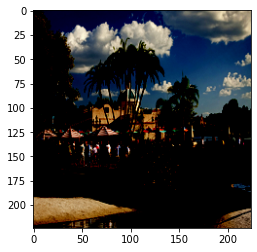

In [160]:
plt.imshow(batch["patch_images"][0].permute(1,2,0).cpu().numpy())

## Test Stack

In [136]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/huggingface/ofa-vqa-base'

In [15]:
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa-bowl'

In [17]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False).cuda()


/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [18]:
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()


In [19]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [23]:
from core.datasets.vqa_gen_dataset import VQACollator, VqaDataset,VqaStackDataset,CLEVRVQADataset


In [21]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/stack_train_questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/images"

In [82]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/Test_set/questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/Test_set/images"


In [83]:
ds_stck = VqaStackDataset(
    ann_file=ann_file,
    vqa_root=vqa_root,
    patch_image_size = resolution,
)
stack_data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
stack_dl = DataLoader(ds_stck, batch_size = 8, collate_fn=stack_data_collator ,num_workers = 0, shuffle = True)


In [20]:
ds_bowl = VqaStackDataset(
    ann_file='/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/bowl_train_questions.json',
    vqa_root='/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/images',
    patch_image_size = resolution,
)
bowl_data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
bowl_dl = DataLoader(ds_bowl, batch_size = 8, collate_fn=bowl_data_collator ,num_workers = 0, shuffle = True)


In [38]:
ds = CLEVRVQADataset(split="valA" , patch_image_size = resolution,)
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [28]:
leonardo_ds = LeonardoVQADataset(
        data_dir = '/srv/scratch/sanisetty3/DLM/sornet/data/leonardo/',
        split="valid",
        patch_image_size=480
    )

data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
leonardo_dl = DataLoader(leonardo_ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = False)


12021

In [139]:
for batch in leonardo_dl:
    break

In [140]:
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True))

[' is the golden block on the parchment colored block?', ' where is the ivory colored block on the table?', ' is there anything on the ivory colored block?', ' which color block on the parchment colored block?', ' is the browny_orange block on the golden colored block?', ' which color block on the ivory colored block?', ' is the robot picking up ivory colored block?', ' where is the browny_orange colored block on the table?', ' is there anything on the browny_orange colored block?', ' where is the ivory colored block on the table?']


In [141]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['yes', 'right', 'no', 'browny_orange', 'no', 'golden', 'no', 'far', 'yes', 'right']


### Pretrained

In [142]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['yes', 'right', 'no', 'browny_orange', 'no', 'golden', 'no', 'far', 'yes', 'right']


In [143]:
gen = model_p.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [144]:
tokenizer_p.batch_decode(gen, skip_special_tokens=True)

[' yes',
 ' in the center of the table',
 ' yes',
 ' green',
 ' yes',
 ' black',
 ' yes',
 ' on the floor',
 ' no',
 ' in the middle']

question:  where is the ivory colored block on the table?
pred:  in the center of the table
target:  right


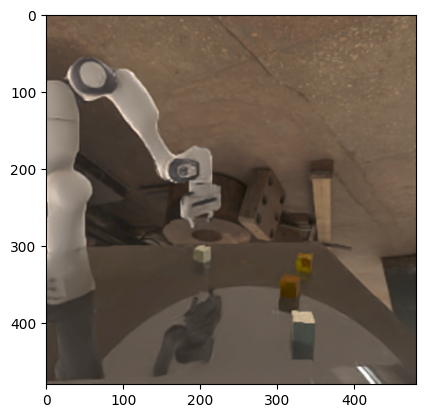

In [145]:
indx = 1
img = batch["patch_images"][indx].permute(1,2,0).cpu().numpy()*[0.5, 0.5, 0.5]+ [0.5, 0.5, 0.5]
plt.imshow(img)
print("question: ", tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print("pred: ",tokenizer_p.batch_decode(gen, skip_special_tokens=True)[indx].strip())
print("target: " , tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True)[indx])

### Finetuned

In [30]:
# for batch in clevr_dl:
#     break

In [146]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['yes', 'right', 'no', 'browny_orange', 'no', 'golden', 'no', 'far', 'yes', 'right']


In [147]:
gen_fin = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)

In [148]:
tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)

['no', 'left', 'no', 'brown', 'no', 'brown', 'no', 'left', 'yes', 'left']

question:  is the golden block on the parchment colored block?
pred:  no
target:  yes


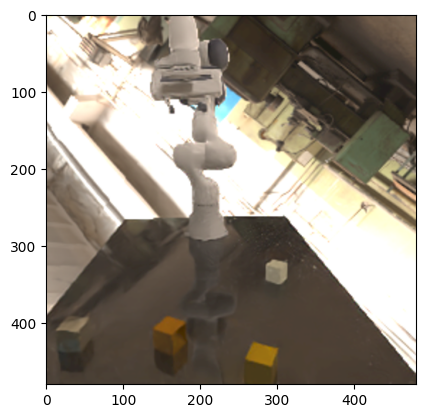

In [150]:
indx = 0
img = batch["patch_images"][indx].permute(1,2,0).cpu().numpy()*[0.5, 0.5, 0.5]+ [0.5, 0.5, 0.5]
plt.imshow(img)
print("question: ", tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print("pred: ",tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)[indx].strip())
print("target: " , tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True)[indx])

## Eval script

In [70]:
from core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset, VqaStackDataset, CLEVRVQADataset,LeonardoVQADataset
import itertools

In [158]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa-bowl/'

In [159]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False).cuda()
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()


/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [73]:
from evaluate import load
bertscore = load("bertscore")

In [168]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/Test_set/questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/Test_set/images"


In [165]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/stack_train_questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/images"

In [160]:
ann_file='/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/bowl_train_questions.json'
vqa_root='/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/images'

In [169]:

stack_ds = VqaStackDataset(
    ann_file=ann_file,
    vqa_root=vqa_root,
)
stack_data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
stack_dl = DataLoader(stack_ds, batch_size = 10, collate_fn=stack_data_collator ,num_workers = 0, shuffle = False)


In [127]:
clevr_ds = CLEVRVQADataset(split="valA")
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
clevr_dl = DataLoader(clevr_ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = False)


In [134]:
print(len(stack_ds) , len(clevr_ds))

108522 150000


In [138]:
leonardo_ds = LeonardoVQADataset(
        data_dir = '/srv/scratch/sanisetty3/DLM/sornet/data/leonardo/',
        split="valid",
        patch_image_size=480
    )

data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
leonardo_dl = DataLoader(leonardo_ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = False)


/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [77]:
def cycle(dl):
    while True:
        for data in dl:
            yield data

## Stack

In [120]:
def get_accuracy(pred , targets):
    count = 0
    for i in range(len(pred)):
        for j in range(pred[0].shape[0]):
            try:
                trs = int(sum(np.setdiff1d(targets[i][j],[0,1,2]) == np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2])) == len(np.setdiff1d(targets[i][j],[0,1,2])))
                #int(sum(np.setdiff1d(targets[i][j],[0,1,2]) == np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2])))
                count+=trs
            except:
                continue          
    print(f"accuracy on {10*len(pred)} points" , count/(10*len(pred)))

In [121]:
def get_bert_score(pred,targets):

    decoded_preds_ = []
    for i in pred:
        decoded_preds_.append(tokenizer_p.batch_decode(i, skip_special_tokens=True))
    decoded_preds = [item for sublist in decoded_preds_ for item in sublist]

    decoded_trg_ = []
    for i in targets:
        decoded_trg_.append(tokenizer_p.batch_decode(i, skip_special_tokens=True))
    decoded_trg = [item for sublist in decoded_preds_ for item in sublist]

    results = bertscore.compute(predictions=decoded_preds, references=decoded_trg, lang="en")
    print(np.mean(results["precision"]))
    print(np.mean(results["recall"]))
    print(np.mean(results["f1"]))

In [170]:
from tqdm import tqdm

targets = []
pred = []
i = 0

# itr = cycle(stack_dl)

for batch in tqdm(stack_dl):
    
    i+=1
    if i>100:
        break

    try:
#         batch = next(itr)
        gen_fin = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
        pred.append(gen_fin)
        targets.append(batch["target"])
    except:
        continue
    
get_accuracy(pred,targets)
get_bert_score(pred,targets)

  8%|███████▊                                                                                           | 100/1274 [00:26<05:06,  3.83it/s]


accuracy on 1000 points 0.383
1.0000000126957893
1.0000000126957893
1.0000000126957893


In [ ]:
'''
f
test: 40%
stack:
bowl:
valA:
valB:


''' 

In [ ]:
'''
p
test: 40%
stack:
bowl:
valA:
valB:


''' 

In [108]:
pred[0]

torch.Size([1, 3])

In [109]:
count = 0
for i in range(len(pred)):
    for j in range(pred[0].shape[0]):
        try:
            trs = int(sum(np.setdiff1d(targets[i][j],[0,1,2]) == np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2])) == len(np.setdiff1d(targets[i][j],[0,1,2])))
            #int(sum(np.setdiff1d(targets[i][j],[0,1,2]) == np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2])))
            count+=trs
        except:
            continue    

In [110]:
count

6

In [71]:
from tqdm import tqdm

targets = []
pred = []
i = 0
for i in tqdm(range(1000)):
    
    
    try:
        itr = cycle(clevr_dl)
        batch = next(itr)
        gen_fin = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
        pred.append(gen_fin)
        targets.append(batch["target"])
    except:
        continue
        
get_accuracy(pred,targets)
get_bert_score(pred,targets)



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:07<00:00,  2.72it/s]


accuracy on 10000 points 1.0
0.9999999821186065
0.9999999821186065
0.9999999821186065


In [106]:
from tqdm import tqdm

targets = []
pred = []
i = 0

# itr = cycle(stack_dl)

for batch in tqdm(stack_dl):

    try:
#         batch = next(itr)
        gen_fin = model_p.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
        pred.append(gen_fin)
        targets.append(batch["target"])
    except:
        continue
    
get_accuracy(pred,targets)
get_bert_score(pred,targets)

# count = 0
# for i in range(len(pred)):
# #     print(i)
#     for j in range(10):
# #         print(np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2]))
#         try:
#             #trs = int(sum(np.setdiff1d(targets[i][j],[0,1,2]) == np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2])))
#             trs = int(sum(np.setdiff1d(targets[1][1],[0,1,2]) == np.setdiff1d(pred[1][1].detach().cpu().numpy(),[0,1,2])) == len(np.setdiff1d(targets[1][1],[0,1,2])))

#             count+=trs
#         except:
#             continue
            
            
# print(f"pretrained accuracy on {10*len(pred)} points" , count/(10*len(pred)))

  0%|                                                                                                         | 0/756 [00:00<?, ?it/s]/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [11:22<00:00,  1.11it/s]


accuracy on 7560 points 0.0
1.0000000654239631
1.0000000654239631
1.0000000654239631


In [21]:
from tqdm import tqdm

targets = []
pred = []
i = 0
for i in tqdm(range(1000)):
    
    
    try:
        itr = cycle(clevr_dl)
        batch = next(itr)
        gen_fin = model_p.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
        pred.append(gen_fin)
        targets.append(batch["target"])
    except:
        continue
        
get_accuracy(pred,targets)
get_bert_score(pred,targets)



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:50<00:00,  1.01s/it]


accuracy on 10000 points 0.0
1.000000073170662
1.000000073170662
1.000000073170662


## CLEVR

In [ ]:
from tqdm import tqdm

targets = []
pred = []
i = 0

# itr = cycle(stack_dl)
#         batch = next(itr)

for batch in stack_dl:

    try:
#         batch = next(itr)
        gen_fin = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
        pred.append(gen_fin)
        targets.append(batch["target"])
    except:
        continue
    
    
    

## Custom image and question

In [49]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa-bowl/'

In [50]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False).cuda()
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()


/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [51]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [52]:
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/images/*.png"
img_list = glob(vqa_root)

In [ ]:
"What color is the block inside the gray bowl?",

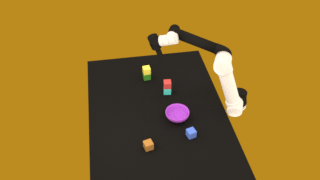

In [67]:
txt = "What color block is above the cyan block?"
inputs = tokenizer_p([txt], return_tensors="pt").input_ids
img = Image.open(img_list[10])
patch_img = patch_resize_transform(img).unsqueeze(0)
img

### Pretrained

In [63]:
custom_gen = model_p.generate(inputs.cuda(), patch_images=patch_img.cuda(), num_beams=5, no_repeat_ngram_size=3)

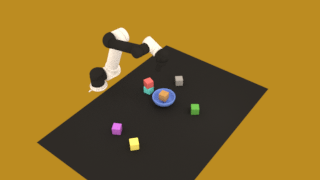

What color is the block inside the gray bowl?
orange


In [64]:
display(img)
print(txt)
print(tokenizer_p.batch_decode(custom_gen, skip_special_tokens=True)[0].strip())

### Fine tuned

In [68]:
custom_gen_fin = model_f.generate(inputs.cuda(), patch_images=patch_img.cuda(), num_beams=5, no_repeat_ngram_size=3)

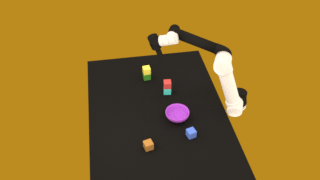

What color block is above the cyan block?
red


In [69]:
display(img)
print(txt)
print(tokenizer_p.batch_decode(custom_gen_fin, skip_special_tokens=True)[0].strip())

## Push to hub

In [153]:
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA
from core.ofa.configuration_ofa import OFAConfig

In [130]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa/'

In [77]:
# fine_tuned ="/coc/scratch/sanisetty3/DLM/OFA-tiny-vqa-finetune/"
# pretrained ='/coc/scratch/sanisetty3/DLM/OFA-tiny/'

tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()
tokenizer_p = OFATokenizer.from_pretrained(finetuned)


In [134]:
# from huggingface_hub import notebook_login

# notebook_login()

In [133]:
# !transformers-cli repo create OFA-base-vqa-finetune

## Cleaning json

In [12]:
import re

In [ ]:
"What color is the <Z2> <C2> <M2> <S2> [that is] <R> the <Z> <C> <M> <S>?",
"What is the color of the <Z2> <C2> <M2> <S2> [that is] <R> the <Z> <C> <M> <S>?",
"The <Z2> <C2> <M2> <S2> [that is] <R> the <Z> <C> <M> <S> is what color?"

<R> includes closest farthest and six directions.

"What number of <Z2> <C2> <M2> <S2>s are <R> the <Z> <C> <M> <S>?",
"How many <Z2> <C2> <M2> <S2>s are <R> the <Z> <C> <M> <S>?"
"Are there any <Z2> <C2> <M2> <S2>s <R> the <Z> <C> <M> <S>?"

In [34]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/bowl_train_questions.json"

In [35]:
with open(ann_file) as f:
    ques = json.load(f)
len(ques["questions"])

11840

In [40]:

r1 = re.compile('.*inside.*cube.*')
r2 = re.compile('.*inside.*block.*')
r3 = re.compile('.*below.*bowl.*')

new_ques_dict = []
for item in ques["questions"]:
    quest = item["question"]
    if r1.match(quest) is not None:
        continue
    if r2.match(quest) is not None:
        continue
    if r3.match(quest) is not None:
        continue
        
    new_ques_dict.append(item)
    
    
new_questions = {"questions" : new_ques_dict}
json_object = json.dumps(new_questions, indent=4)
 
# Writing to sample.json
with open("/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/bowl_train_questions.json", "w") as outfile:
    outfile.write(json_object)

In [41]:
len(new_ques_dict)

11797

In [42]:
11840 - 11797

43

In [43]:
json_object = json.dumps(new_questions, indent=4)
 
# Writing to sample.json
with open("/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/bowl_train_questions.json", "w") as outfile:
    outfile.write(json_object)